# Two sides of the same coin: Beneficial and detrimental consequences of range adaptation in human reinforcement learning
This is my implementation of this paper, done with the purpose of understanding it in depth

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

## Range Model

Formula for calculating the relative reward

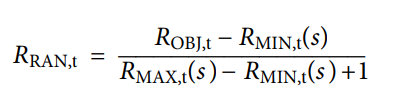

In [2]:
class Experiment:

    def __init__(self, option1=10, option2=10, probability1=75, probability2=25):
        self.options = [option1, option2]
        self.probabilities = [probability1, probability2]
    
    def rollReward(self, choice=0):
        """
        Choice has to be either 0 or 1.

        Returns either the reward or 0.
        """

        options = [self.options[choice], 0]
        probabilities = [self.probabilities[choice], 100 - self.probabilities[choice]]

        return random.choices(options, probabilities)[0] # Tengo que regresar las recompensas normalizadas

In [16]:
class Agent:
    
    def __init__(self, num_choices=2, discount_factor=0.9, epsilon=0.1):
        self.q_values = np.zeros(num_choices)
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.rMin = 0
        self.rMax = 0

    def select_action(self):
        if np.random.rand() < self.epsilon: # Explore
            return np.random.randint(len(self.q_values))
        else: # Exploit
            return np.argmax(self.q_values)
        
    def update_q_values(self, action, reward, step):
        learning_rate = 1/step
        self.q_values[action] = self.q_values[action] + learning_rate*(reward - self.q_values[action])

    def update_q_values_normalized(self, action, reward, step):
        # Normalize the reward
        self.rMin = min(self.rMin, reward)
        self.rMax = max(self.rMax, reward)
        reward = (reward - self.rMin) / (self.rMax - self.rMin + 1)
        learning_rate = 1/step
        
        self.q_values[action] = self.q_values[action] + learning_rate*(reward - self.q_values[action])

In [17]:
# Baseline comparision
baseline10Experiment = Experiment(10, 10, 75, 25) # Rewards of 10, with 75% and 25% probability respectively
baseline1Experiment = Experiment(1, 1, 75, 25) # Rewards of 1, with 75% and 25% probability respectively

r1, r2, r3, r4 = 0, 0, 0, 0

for i in range(1000):
    r1 += baseline10Experiment.rollReward(0)
    r2 += baseline10Experiment.rollReward(1)
    r3 += baseline1Experiment.rollReward(0)
    r4 += baseline1Experiment.rollReward(1)

print("10 with 75%:", r1)
print("10 with 25%:", r2)
print("1 with 75%:", r3)
print("1 with 25%:", r4)

10 with 75%: 7560
10 with 25%: 2440
1 with 75%: 751
1 with 25%: 250


In [18]:
def train_agent(episodes=1000, experiment=Experiment(10, 10, 75, 25), agent=Agent()):
    rewards = []
    avg_rewards = []

    for episode in range(1,episodes):
        action = agent.select_action()
        reward = experiment.rollReward(action)
        agent.update_q_values(action, reward, episode)
        rewards.append(reward)
        avg_rewards.append(np.average(rewards))

    print('Q-table:', agent.q_values)

    return avg_rewards, agent.q_values

def train_agent_normalized(episodes=1000, experiment=Experiment(10, 10, 75, 25), agent=Agent()):
    rewards = []
    avg_rewards = []

    for episode in range(1,episodes):
        action = agent.select_action()
        reward = experiment.rollReward(action)
        agent.update_q_values_normalized(action, reward, episode)
        rewards.append(reward)
        avg_rewards.append(np.average(rewards))

    print('Q-table:', agent.q_values)

    return avg_rewards, agent.q_values

Q-table: [7.5013092  0.70224588]


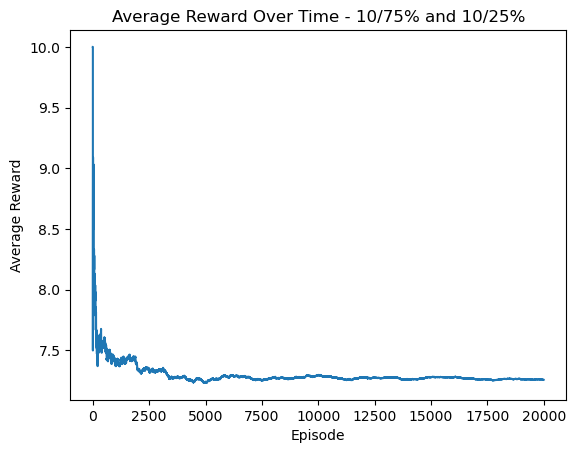

In [19]:
# Rewards of 10, with 75% and 25% probability respectively

experiment = Experiment(10, 10, 75, 25)
agent = Agent()
steps = 20000

avg_rewards, q_values1 = train_agent(steps, experiment, agent)

# Visualization

plt.plot(avg_rewards)
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Average Reward Over Time - 10/75% and 10/25%')
plt.show()


Q-table: [0.74443611 0.08537837]


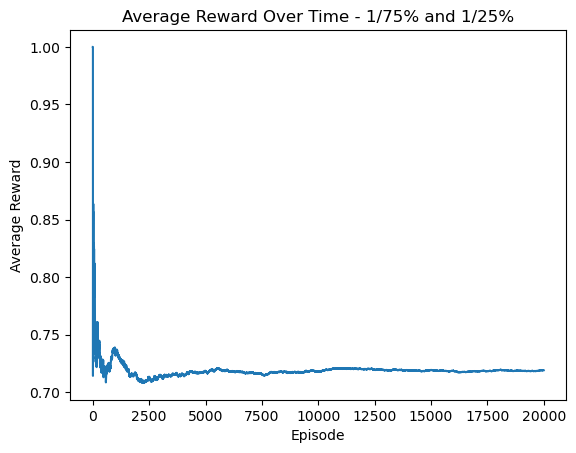

In [20]:
 # Rewards of 1, with 75% and 25% probability respectively

experiment = Experiment(1, 1, 75, 25)
agent = Agent()
steps = 20000

avg_rewards, q_values2 = train_agent(steps, experiment, agent)

# Visualization

plt.plot(avg_rewards)
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Average Reward Over Time - 1/75% and 1/25%')
plt.show()


Q-table: [0.68394091 0.11131856]


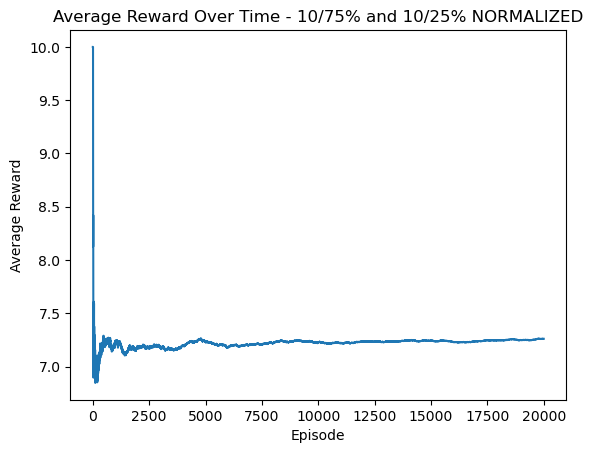

In [21]:
# Rewards of 10, with 75% and 25% probability respectively

experiment = Experiment(10, 10, 75, 25)
agent = Agent()
steps = 20000

avg_rewards, q_values1_norm = train_agent_normalized(steps, experiment, agent)

# Visualization

plt.plot(avg_rewards)
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Average Reward Over Time - 10/75% and 10/25% NORMALIZED')
plt.show()


Q-table: [0.75232125 0.0610899 ]


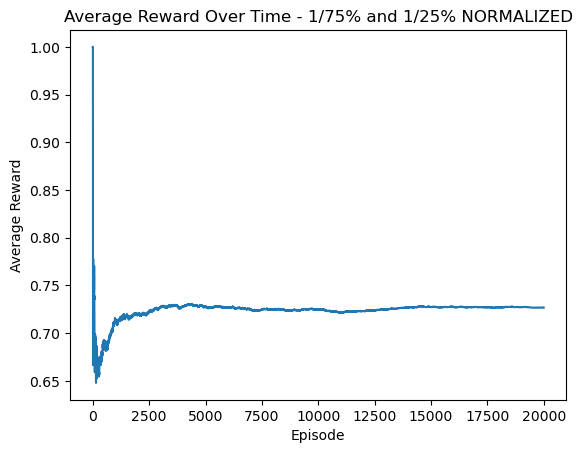

In [22]:
 # Rewards of 1, with 75% and 25% probability respectively

experiment = Experiment(1, 1, 75, 25)
agent = Agent()
steps = 20000

avg_rewards, q_values2_norm = train_agent(steps, experiment, agent)

# Visualization

plt.plot(avg_rewards)
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Average Reward Over Time - 1/75% and 1/25% NORMALIZED')
plt.show()


## Policy Learning

Studying the effects of action values and beta

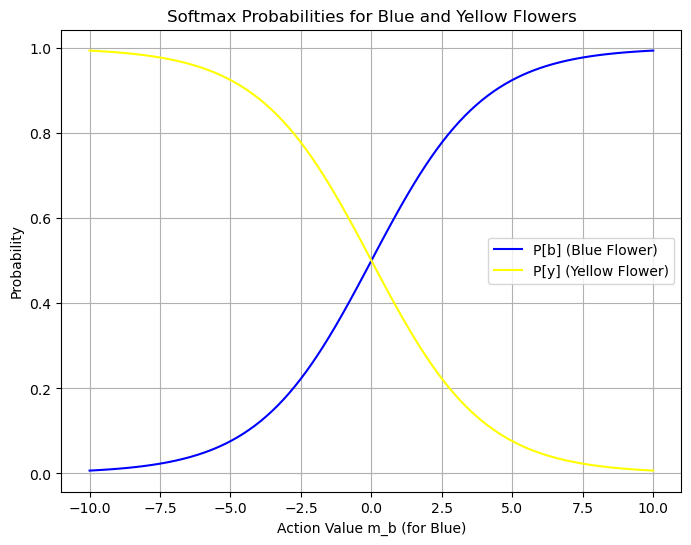

In [22]:
# Define the softmax function
def softmax(m_b, m_y, beta):
    P_b = np.exp(beta * m_b) / (np.exp(beta * m_b) + np.exp(beta * m_y))
    P_y = np.exp(beta * m_y) / (np.exp(beta * m_b) + np.exp(beta * m_y))
    return P_b, P_y

# Action values (m_b and m_y)
m_b_values = np.linspace(-10, 10, 100)  # Varying m_b from -10 to 10
m_y = 0  # Keep m_y constant
beta = 0.5  # Constant beta

# Calculate probabilities
P_b_values = []
P_y_values = []
for m_b in m_b_values:
    P_b, P_y = softmax(m_b, m_y, beta)
    P_b_values.append(P_b)
    P_y_values.append(P_y)

# Plotting
plt.figure(figsize=(8, 6))
fig = plt.plot(m_b_values, P_b_values, label='P[b] (Blue Flower)', color='blue')
plt.plot(m_b_values, P_y_values, label='P[y] (Yellow Flower)', color='yellow')
plt.xlabel('Action Value m_b (for Blue)')
plt.ylabel('Probability')
plt.title('Softmax Probabilities for Blue and Yellow Flowers')
plt.legend()
plt.grid(True)
plt.show()


Constant m_b and m_y

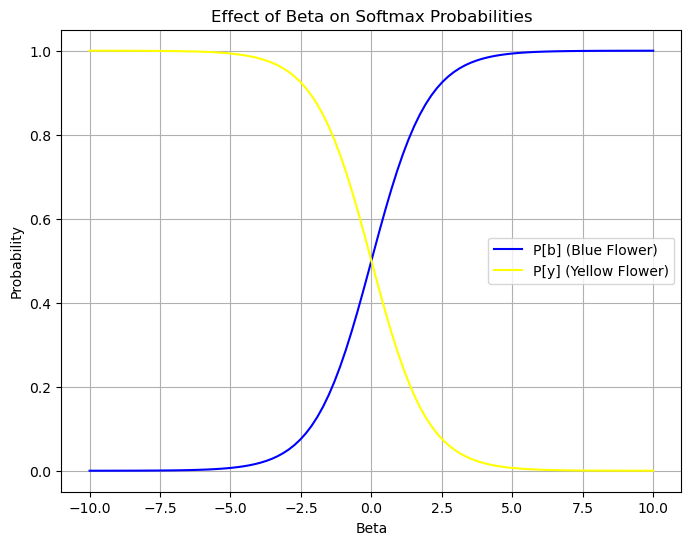

In [11]:
# Fix m_b and m_y and vary beta
m_b = 3  # Fixed action value for blue flower
m_y = 2  # Fixed action value for yellow flower
beta_values = np.linspace(-10, 10, 100)  # Varying beta from 0.1 to 10

# Calculate probabilities
P_b_values = []
P_y_values = []
for beta in beta_values:
    P_b, P_y = softmax(m_b, m_y, beta)
    P_b_values.append(P_b)
    P_y_values.append(P_y)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(beta_values, P_b_values, label='P[b] (Blue Flower)', color='blue')
plt.plot(beta_values, P_y_values, label='P[y] (Yellow Flower)', color='yellow')
plt.xlabel('Beta')
plt.ylabel('Probability')
plt.title('Effect of Beta on Softmax Probabilities')
plt.legend()
plt.grid(True)
plt.show()


Learning rule

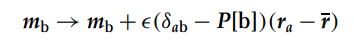

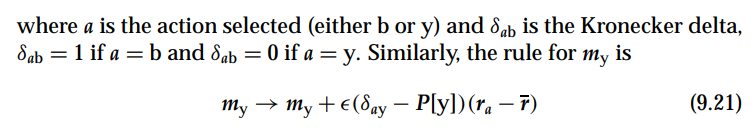

In [ ]:
class PolicyAgent:
    """
    Policy learning Actor with two choices.
    """

    def __init__(self, epsilon=0.1, mean_r=1.5, beta=1):
        # Hyperparameters
        self.epsilon = epsilon
        self.beta = beta
        
        self.mean_r = mean_r # r_prom = r_prom + lr * (r - r_prom), se actualiza antes de cada cambio a los action values
        
        # Action values
        self.m1 = 0
        self.m2 = 0

        # Action probabilities
        self.prob1 = 0.5
        self.prob2 = 0.5
    
    def softmax(self):
        self.prob1 = np.exp(self.beta * self.m1) / (np.exp(self.beta * self.m1) + np.exp(self.beta * self.m2))
        self.prob2 = np.exp(self.beta * self.m2) / (np.exp(self.beta * self.m1) + np.exp(self.beta * self.m2))
    
    def update_actionValues(self, kDelta, reward):
        """
        kDelta is Kronecker Delta in the form of a tuple. Index 0 is for m1 and index 1 is for m2
        """
        self.m1 = self.m1 + self.epsilon * (kDelta[0] - self.prob1) * (reward - self.mean_r)
        self.m2 = self.m2 + self.epsilon * (kDelta[1] - self.prob2) * (reward - self.mean_r)

    def select_action(self):
        # Pick either option 1 or 2 based on the probabilities for each action.
        reward = 

        return reward